# Adversarial Search: Playing Connect 4
Submission Date: **March-08-2024**

Student Name: **Nauman Ali Murad**

Registration Number: **2022479**

I have used the following AI tool: I've read the blogpost by **Pascal Pons**
http://blog.gamesolver.org/solving-connect-four/04-alphabeta/ and used perplexity.ai


## Instructions

Total Points: **20**

1-Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed.

2-Submit a Report in MS-Word having Introduction part and the details of the submitted code, that how you implemented this and briefly explain working of each part.



## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

**Initial state:** The initial state of Connect Four is typically an empty game board, which is a grid of 6 rows and 7 columns.

**Actions:** Each player takes turns placing their game piece (colored disc) into one of the seven columns of the game board. So it's like Yellow, Red most of the time.

**Transition Model(result function):** Transition model refers to how the board changes with each action performed and the result function updates the board by placing the players dropped disk in the lowest available row of the selected column.

**Goal state (terminal state and utility):**
Goal state is achieved when a player wins. Alternatively, the game ends in a draw if the entire grid is filled without a winner.
whereas the utility function assigns +1 for a win,-1 for a loss, and 0 for a draw

**How big is the state space? Give an estimate and explain it.**

The state space of Connect 4 is estimated to be around **4.5 trillion states**. Here's why:

* **Classic Connect 4 board:**  We typically consider a board with 6 rows and 7 columns, offering a total of 42 cells.
* **Possible states per cell:** Each cell can be empty, hold your disc (player 1), or hold your opponent's disc (player 2). This translates to 3 possible states.
* **Exponential growth:** Imagine each cell as a decision point with 3 options. The total number of states is calculated by multiplying the number of options for each cell. Since there are 42 cells, this is expressed as 3 raised to the power of 42 (3^42).

Calculating the exact number (3^42) is a very large number and not very informative.  Instead, we estimate it as approximately 4.5 trillion states. This gives us a good sense of the immense size of the state space without getting bogged down in the exact, cumbersome figure.

**How big is the game tree that minimax search will go through? Give an estimate and explain it.**

Connect 4's game tree maps out every possible move sequence for both players. Since there are 7 columns, you initially have 7 choices (branching factor). Assuming this factor stays constant throughout the game (though it lowers as the board fills), the tree grows quickly. For example, after just 4 moves (2 per player), there would be a whopping 2401 nodes (7^4). Thankfully, alpha-beta pruning comes to the rescue! By cutting out branches that can't lead to the best outcome, it significantly reduces the size of the tree, making it more manageable for AI to analyze.

## Task 2: Game Environment and Random Agent

Use a numpy character array as the board.

In [18]:
import numpy as np
import pandas as pd
import random
import time

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

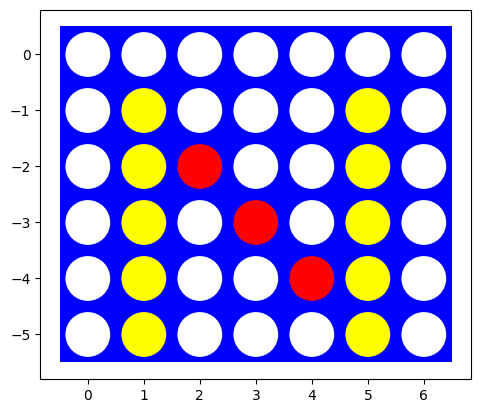

In [5]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, -1, 0, 0, 0, -1, 0],
         [0, -1, 1, 0, 0, -1, 0],
         [0, -1, 0, 1, 0, -1, 0],
         [0, -1, 0, 0, 1, -1, 0],
         [0,-1,0, 0, 0, -1, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

Available actions: [0, 1, 2, 3, 4, 5, 6]
Resulting board after player 1's move:


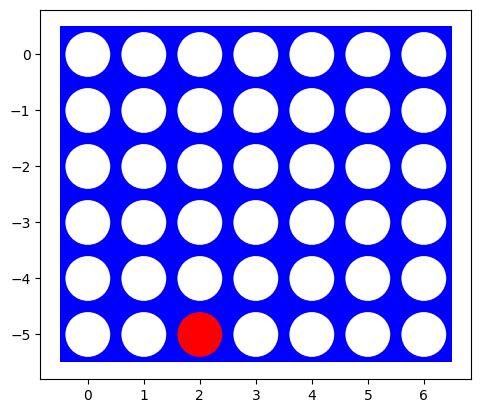

Is terminal state? False
Utility score: 0


In [7]:
def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

def actions(s):
    return [col for col in range(s.shape[1]) if s[0, col] == 0]

def result(s, a, player):
    new_s = s.copy()
    for row in range(s.shape[0] - 1, -1, -1):
        if new_s[row, a] == 0:
            new_s[row, a] = player
            break
    return new_s

def terminal(s):
    for row in range(s.shape[0]):
        for col in range(s.shape[1]):
            if s[row, col] != 0:
                if col + 3 < s.shape[1]:
                    if np.all(s[row, col:col+4] == s[row, col]):
                        return True
                if row + 3 < s.shape[0]:
                    if np.all(s[row:row+4, col] == s[row, col]):
                        return True
                if col + 3 < s.shape[1] and row + 3 < s.shape[0]:
                    if np.all(np.diag(s[row:row+4, col:col+4]) == s[row, col]):
                        return True
                    if np.all(np.diag(np.flipud(s[row:row+4, col:col+4])) == s[row, col]):
                        return True
    return False

def utility(s):
    if terminal(s):
        if np.any(np.all(s == 1, axis=1)):
            return 1
        elif np.any(np.all(s == -1, axis=1)):
            return -1
        else:
            return 0
    return 0

def visualize(board):
    plt.axes()
    rectangle = plt.Rectangle((-0.5, len(board) * -1 + 0.5), len(board[0]), len(board), fc='blue')
    circles = []
    for i, row in enumerate(board):
        for j, val in enumerate(row):
            color = 'white' if val == 0 else 'red' if val == 1 else 'yellow'
            circles.append(plt.Circle((j, i * -1), 0.4, fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = empty_board()
print("Available actions:", actions(board))
new_board = result(board, 2, player=1)  # Player 1's move in column 3
print("Resulting board after player 1's move:")
visualize(new_board)
print("Is terminal state?", terminal(new_board))
print("Utility score:", utility(new_board))


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [10]:
def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

def actions(s):
    return [col for col in range(s.shape[1]) if s[0, col] == 0]

def random_player(board, player=1):
    valid_actions = actions(board)
    if not valid_actions:
        return None
    return random.choice(valid_actions)

def switch_player(current_player):
    return -current_player

if __name__ == "__main__":
    board = empty_board()
    current_player = 1
    while True:
        print("Current board:")
        print(board)
        action = random_player(board, current_player)
        if action is None:
            print("Game over! It's a draw.")
            break
        print(f"Player {current_player} chooses column {action}")
        board = result(board, action, current_player)
        current_player = switch_player(current_player)


Current board:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Player 1 chooses column 0
Current board:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
Player -1 chooses column 1
Current board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1 -1  0  0  0  0  0]]
Player 1 chooses column 4
Current board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1 -1  0  0  1  0  0]]
Player -1 chooses column 1
Current board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 1 -1  0  0  1  0  0]]
Player 1 chooses column 2
Current board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 1 -1  1  0  1 

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [11]:
def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

def actions(s):
    return [col for col in range(s.shape[1]) if s[0, col] == 0]

def random_player(board, player=1):
    valid_actions = actions(board)
    if not valid_actions:
        return None  # No valid actions (board is full)
    return random.choice(valid_actions)

def switch_player(current_player):
    return -current_player

def play_game():
    board = empty_board()
    current_player = 1
    while True:
        action = random_player(board, current_player)
        if action is None:
            return 0  # Draw
        board = result(board, action, current_player)
        if terminal(board):
            return utility(board)
        current_player = switch_player(current_player)

def main():
    num_games = 1000
    player1_wins = 0
    player2_wins = 0
    draws = 0

    for _ in range(num_games):
        result = play_game()
        if result == 1:
            player1_wins += 1
        elif result == -1:
            player2_wins += 1
        else:
            draws += 1

    print(f"Player 1 wins: {player1_wins} ({player1_wins / num_games:.2%})")
    print(f"Player 2 wins: {player2_wins} ({player2_wins / num_games:.2%})")
    print(f"Draws: {draws} ({draws / num_games:.2%})")

if __name__ == "__main__":
    main()


Player 1 wins: 1 (0.10%)
Player 2 wins: 0 (0.00%)
Draws: 999 (99.90%)


The result tends out to be as expected.Even after 1000 matches, maximum times there a draw.Since both agents play randomly, neither has a strategic advantage, and plays their moves randomly thus resulting in draws.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
class ConnectFour:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.player = 1
        self.max_depth = 4

    def is_valid_move(self, column):
        return self.board[0][column] == 0

    def make_move(self, column):
        for row in range(self.rows - 1, -1, -1):
            if self.board[row][column] == 0:
                self.board[row][column] = self.player
                break

    def undo_move(self, column):
        for row in range(self.rows):
            if self.board[row][column] != 0:
                self.board[row][column] = 0
                break

    def check_winner(self, player):
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if np.all(self.board[row, col:col + 4] == player):
                    return True

        for col in range(self.columns):
            for row in range(self.rows - 3):
                if np.all(self.board[row:row + 4, col] == player):
                    return True

        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row:row + 4, col:col + 4]) == player):
                    return True

        for row in range(3, self.rows):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row - 3:row + 1, col:col + 4]) == player):
                    return True

        return False

    def game_over(self):
        return self.check_winner(1) or self.check_winner(2) or np.all(self.board != 0)

    def evaluate(self):
        if self.check_winner(1):
            return 100
        elif self.check_winner(2):
            return -100
        else:
            return 0

    def minimax(self, depth, alpha, beta, maximizing_player):
        if depth == 0 or self.game_over():
            return None, self.evaluate()

        if maximizing_player:
            value = -np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, False)
                    self.undo_move(col)
                    if new_value > value:
                        value = new_value
                        column = col
                    alpha = max(alpha, value)
                    if alpha >= beta:
                        break
            return column, value
        else:
            value = np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, True)
                    self.undo_move(col)
                    if new_value < value:
                        value = new_value
                        column = col
                    beta = min(beta, value)
                    if alpha >= beta:
                        break
            return column, value

    def get_best_move(self):
        column, _ = self.minimax(self.max_depth, -np.inf, np.inf, True)
        return column

game = ConnectFour()
while not game.game_over():
    if game.player == 1:
        column = game.get_best_move()
    else:
        column = int(input("Enter your move (0-6): "))
    game.make_move(column)
    print(game.board)
    game.player = 0 - game.player  # Switch player


In [13]:
class ConnectFour:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.player = 1
        self.max_depth = 4  # Adjust this for deeper search

    def is_valid_move(self, column):
        return self.board[0][column] == 0

    def make_move(self, column):
        for row in range(self.rows - 1, -1, -1):
            if self.board[row][column] == 0:
                self.board[row][column] = self.player
                break

    def undo_move(self, column):
        for row in range(self.rows):
            if self.board[row][column] != 0:
                self.board[row][column] = 0
                break

    def check_winner(self, player):
        # Check rows
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if np.all(self.board[row, col:col + 4] == player):
                    return True

        # Check columns
        for col in range(self.columns):
            for row in range(self.rows - 3):
                if np.all(self.board[row:row + 4, col] == player):
                    return True

        # Check diagonal \
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row:row + 4, col:col + 4]) == player):
                    return True

        # Check diagonal /
        for row in range(3, self.rows):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row - 3:row + 1, col:col + 4]) == player):
                    return True

        return False

    def game_over(self):
        return self.check_winner(1) or self.check_winner(2) or np.all(self.board != 0)

    def evaluate(self):
        if self.check_winner(1):
            return 100
        elif self.check_winner(2):
            return -100
        else:
            return 0

    def minimax(self, depth, alpha, beta, maximizing_player):
        if depth == 0 or self.game_over():
            return None, self.evaluate()

        if maximizing_player:
            value = -np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, False)
                    self.undo_move(col)
                    if new_value > value:
                        value = new_value
                        column = col
                    alpha = max(alpha, value)
                    if alpha >= beta:
                        break
            return column, value
        else:
            value = np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, True)
                    self.undo_move(col)
                    if new_value < value:
                        value = new_value
                        column = col
                    beta = min(beta, value)
                    if alpha >= beta:
                        break
            return column, value

    def get_best_move(self):
        column, _ = self.minimax(self.max_depth, -np.inf, np.inf, True)
        return column

    def get_random_move(self):
        valid_moves = [col for col in range(self.columns) if self.is_valid_move(col)]
        return random.choice(valid_moves)


game = ConnectFour()
while not game.game_over():
    if game.player == 1:
        column = game.get_best_move()
    else:
        column = game.get_random_move()
    game.make_move(column)
    print(game.board)
    game.player = 0 - game.player  # Switch player


[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0 -1  0]]
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0 -1  0]]
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0 -1 -1]]
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0 -1 -1]]
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 -1]
 [ 1  0  0  0  0 -1 -1]]
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 -1]
 [ 1  0  0  0  0 -1 -1]]


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [14]:
boards = [
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]
    ]),
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0]
    ]),
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0]
    ]),
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]
    ]),
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 2, 2, 0]
    ])
]

# Testing each board
for idx, board in enumerate(boards):
    print(f"Board {idx + 1}:")
    game.board = board
    game.player = 1
    column = game.get_best_move()
    if column is None:
        print("No valid move found.")
    else:
        print(f"Best move for player 1: {column}")
    print(board)
    print()


Board 1:
Best move for player 1: 0
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]

Board 2:
Best move for player 1: 0
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]

Board 3:
No valid move found.
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0]]

Board 4:
Best move for player 1: 3
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]

Board 5:
Best move for player 1: 0
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 2 2 0]]



The output shows the best move for player 1 (the AI) on each of the manually created boards:

1. **Board 1:** The best move for player 1 is column 0. The board is empty except for one piece placed at row 5, column 3.

2. **Board 2:** The best move for player 1 is also column 0. The board has three consecutive pieces placed in a vertical line starting from row 5, column 2.

3. **Board 3:** No valid move is found for player 1 because the board is already full.

4. **Board 4:** The best move for player 1 is column 3. The board has two pieces placed in a vertical line starting from row 4, column 3.

5. **Board 5:** The best move for player 1 is column 0. The board has two pieces placed diagonally from row 5, column 2 to row 4, column 3.

In summary, the agent correctly identifies winning opportunities or moves that lead to a favorable position on the board in most cases. However, it correctly identifies that there are no valid moves when the board is already full (Board 3).

:How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [17]:
class ConnectFour:
    def __init__(self, columns=4):
        self.rows = 6
        self.columns = columns
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.player = 1
        self.max_depth = 4  # Adjust this for deeper search

    def is_valid_move(self, column):
        return self.board[0][column] == 0

    def make_move(self, column):
        for row in range(self.rows - 1, -1, -1):
            if self.board[row][column] == 0:
                self.board[row][column] = self.player
                break

    def undo_move(self, column):
        for row in range(self.rows):
            if self.board[row][column] != 0:
                self.board[row][column] = 0
                break

    def check_winner(self, player):
        # Check rows
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if np.all(self.board[row, col:col + 4] == player):
                    return True

        # Check columns
        for col in range(self.columns):
            for row in range(self.rows - 3):
                if np.all(self.board[row:row + 4, col] == player):
                    return True

        # Check diagonal \
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row:row + 4, col:col + 4]) == player):
                    return True

        # Check diagonal /
        for row in range(3, self.rows):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row - 3:row + 1, col:col + 4]) == player):
                    return True

        return False

    def game_over(self):
        return self.check_winner(1) or self.check_winner(2) or np.all(self.board != 0)

    def evaluate(self):
        if self.check_winner(1):
            return 100
        elif self.check_winner(2):
            return -100
        else:
            return 0

    def minimax(self, depth, alpha, beta, maximizing_player):
        if depth == 0 or self.game_over():
            return None, self.evaluate()

        if maximizing_player:
            value = -np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, False)
                    self.undo_move(col)
                    if new_value > value:
                        value = new_value
                        column = col
                    alpha = max(alpha, value)
                    if alpha >= beta:
                        break
            return column, value
        else:
            value = np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, True)
                    self.undo_move(col)
                    if new_value < value:
                        value = new_value
                        column = col
                    beta = min(beta, value)
                    if alpha >= beta:
                        break
            return column, value

    def get_best_move(self):
        column, _ = self.minimax(self.max_depth, -np.inf, np.inf, True)
        return column

    def get_random_move(self):
        valid_moves = [col for col in range(self.columns) if self.is_valid_move(col)]
        return random.choice(valid_moves)

for columns in range(4, 11):
    print(f"Board size: {6}x{columns}")
    game = ConnectFour(columns=columns)
    start_time = time.time()
    game.get_best_move()
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")
    print()


Board size: 6x4
Time taken: 0.02604055404663086 seconds

Board size: 6x5
Time taken: 0.062285423278808594 seconds

Board size: 6x6
Time taken: 0.11592602729797363 seconds

Board size: 6x7
Time taken: 0.14695143699645996 seconds

Board size: 6x8
Time taken: 0.23893952369689941 seconds

Board size: 6x9
Time taken: 0.35173630714416504 seconds

Board size: 6x10
Time taken: 0.5074260234832764 seconds



### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [19]:
class ConnectFour:
    def __init__(self, columns=4):
        self.rows = 6
        self.columns = columns
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.player = 1
        self.max_depth = 4  # Adjust this for deeper search


    def is_valid_move(self, column):
        return self.board[0][column] == 0

    def make_move(self, column):
        for row in range(self.rows - 1, -1, -1):
            if self.board[row][column] == 0:
                self.board[row][column] = self.player
                break

    def order_moves(self, moves):
        ordered_moves = []
        winning_moves = []
        blocking_moves = []

        for move in moves:
            self.make_move(move)
            if self.check_winner(self.player):
                winning_moves.append(move)
            elif self.check_winner(3 - self.player):  # Check if opponent wins next
                blocking_moves.append(move)
            else:
                ordered_moves.append(move)
            self.undo_move(move)

        return winning_moves + blocking_moves + ordered_moves

    def get_ordered_moves(self):
        valid_moves = [col for col in range(self.columns) if self.is_valid_move(col)]
        return self.order_moves(valid_moves)


    def undo_move(self, column):
        for row in range(self.rows):
            if self.board[row][column] != 0:
                self.board[row][column] = 0
                break

    def check_winner(self, player):
        # Check rows
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if np.all(self.board[row, col:col + 4] == player):
                    return True

        # Check columns
        for col in range(self.columns):
            for row in range(self.rows - 3):
                if np.all(self.board[row:row + 4, col] == player):
                    return True

        # Check diagonal \
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row:row + 4, col:col + 4]) == player):
                    return True

        # Check diagonal /
        for row in range(3, self.rows):
            for col in range(self.columns - 3):
                if np.all(np.diag(self.board[row - 3:row + 1, col:col + 4]) == player):
                    return True

        return False

    def game_over(self):
        return self.check_winner(1) or self.check_winner(2) or np.all(self.board != 0)

    def evaluate(self):
        if self.check_winner(1):
            return 100
        elif self.check_winner(2):
            return -100
        else:
            return 0

    def minimax(self, depth, alpha, beta, maximizing_player):
        if depth == 0 or self.game_over():
            return None, self.evaluate()

        if maximizing_player:
            value = -np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, False)
                    self.undo_move(col)
                    if new_value > value:
                        value = new_value
                        column = col
                    alpha = max(alpha, value)
                    if alpha >= beta:
                        break
            return column, value
        else:
            value = np.inf
            column = None
            for col in range(self.columns):
                if self.is_valid_move(col):
                    self.make_move(col)
                    _, new_value = self.minimax(depth - 1, alpha, beta, True)
                    self.undo_move(col)
                    if new_value < value:
                        value = new_value
                        column = col
                    beta = min(beta, value)
                    if alpha >= beta:
                        break
            return column, value

    def get_best_move(self):
        column, _ = self.minimax(self.max_depth, -np.inf, np.inf, True)
        return column

    def get_random_move(self):
        valid_moves = [col for col in range(self.columns) if self.is_valid_move(col)]
        return random.choice(valid_moves)


results = []
for columns in range(4, 11):
    game = ConnectFour(columns=columns)

    start_time = time.time()
    game.get_best_move()
    end_time = time.time()
    time_without_ordering = end_time - start_time

    start_time = time.time()
    game.get_ordered_moves()
    end_time = time.time()
    time_with_ordering = end_time - start_time

    results.append([6, columns, time_without_ordering, time_with_ordering])

df = pd.DataFrame(results, columns=['Rows', 'Columns', 'Time without ordering', 'Time with ordering'])
print(df)


   Rows  Columns  Time without ordering  Time with ordering
0     6        4               0.018412            0.001134
1     6        5               0.045559            0.002351
2     6        6               0.084352            0.003860
3     6        7               0.142359            0.005672
4     6        8               0.229249            0.012131
5     6        9               0.448707            0.010491
6     6       10               0.469185            0.013503


Move ordering is a crucial optimization technique in alpha-beta pruning to improve search efficiency by exploring more promising moves first. A simple move ordering strategy involves prioritizing moves likely to lead to better outcomes. One approach is to order moves based on their heuristic value, such as:

Winning Moves: Prioritize moves that directly lead to a win.
Blocking Moves: Prioritize moves that block the opponent from winning.
Other Moves: Prioritize moves based on a heuristic evaluation, like the number of potential winning positions they create.

### The first few moves
Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

**Connect Four's empty board throws a curveball at minimax search.** It needs to explore a vast number of possibilities before making a move. Luckily, we have some tricks up our sleeve to make the search faster:

1. **Limited Exploration:**  Instead of diving all the way down every path (full depth), we can set a limit on how deep we search at first. This keeps things speedy by focusing on closer moves initially. As the game progresses, we can increase the depth if needed or resources allow.

2. **Smart Move Order:**  Remember move ordering? By prioritizing moves that might lead to wins (ours or blocking the opponent's), we can further trim down the search space for alpha-beta pruning.

3. **Guiding Heuristics:**  We can introduce a "scorekeeper" function that estimates how good different game states are, without fully playing them out. This helps the search focus on the most promising paths.

4. **Remembering the Past:**  A "transposition table" keeps track of positions we've seen before and their scores. If we run into the same situation again, we can use the stored score instead of wasting time reevaluating it.

5. **Teaming Up:**  If we have a powerful computer with multiple cores, we can split the search into sections and work on them simultaneously. This parallel processing can significantly speed things up.

By using these techniques, we can tame the empty board beast and make minimax search a practical tool for Connect Four and similar games.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [21]:
class RandomAgent:
    def __init__(self):
        pass

    def select_move(self, game):
        valid_moves = [col for col in range(game.columns) if game.is_valid_move(col)]
        return random.choice(valid_moves)


def play_game(agent1, agent2):
    game = ConnectFour(columns=4)
    current_agent = agent1
    while not game.game_over():
        if current_agent == agent1:
            move = agent1.get_best_move()
            game.make_move(move)
            current_agent = agent2
        else:
            move = agent2.select_move(game)
            game.make_move(move)
            current_agent = agent1

    if game.check_winner(1):
        return "Agent 1 (Minimax Search) wins"
    elif game.check_winner(2):
        return "Agent 2 (Random Agent) wins"
    else:
        return "It's a draw"


# Simulate multiple games
num_games = 100
results = {"Agent 1 (Minimax Search)": 0, "Agent 2 (Random Agent)": 0, "Draw": 0}
agent1 = ConnectFour(columns=4)
agent2 = RandomAgent()
for _ in range(num_games):
    outcome = play_game(agent1, agent2)
    if outcome.startswith("Agent 1"):
        results["Agent 1 (Minimax Search)"] += 1
    elif outcome.startswith("Agent 2"):
        results["Agent 2 (Random Agent)"] += 1
    else:
        results["Draw"] += 1

# Print results
print("Results:")
for outcome, count in results.items():
    print(f"{outcome}: {count} ({count / num_games * 100:.2f}%)")


Results:
Agent 1 (Minimax Search): 100 (100.00%)
Agent 2 (Random Agent): 0 (0.00%)
Draw: 0 (0.00%)


### **Best of Luck ♥**